# Обучение unet-модели для предсказания изменения ландшафта на спутниковом снимке

Устанавливаем и импортируем все требуемые завивисмости

In [1]:
%pip install kornia

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torch import nn
from torchvision import transforms
from tqdm.notebook import tqdm
import random

from torch.utils.data import DataLoader
from PIL import Image

from diffusers import DDPMScheduler, UNet2DModel
from utils import show_images, unfold_batch_n_times
from dataset import PatchesDataset

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/home/jupyter/.local/lib/python3.10/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)
2024-09-04 10:11:09.379889: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


Подготовим данные

In [4]:
transform_low_res = transforms.Compose([
    torchvision.ops.Permute([2, 0, 1]),
    transforms.Resize((32, 32), antialias=True),
])

transform_high_res = transforms.Compose([
    torchvision.ops.Permute([2, 0, 1]),
    transforms.Resize((64, 64), antialias=True),
])

dataset = PatchesDataset(transform_low_res, transform_high_res)
train_dataloader = DataLoader(dataset, batch_size=6, shuffle=True)

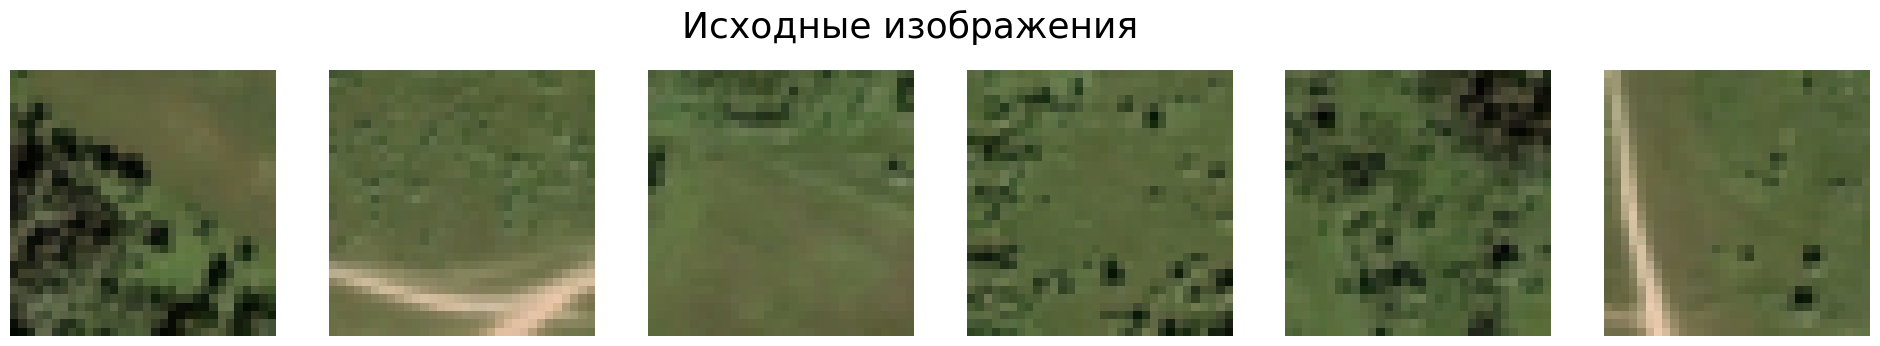

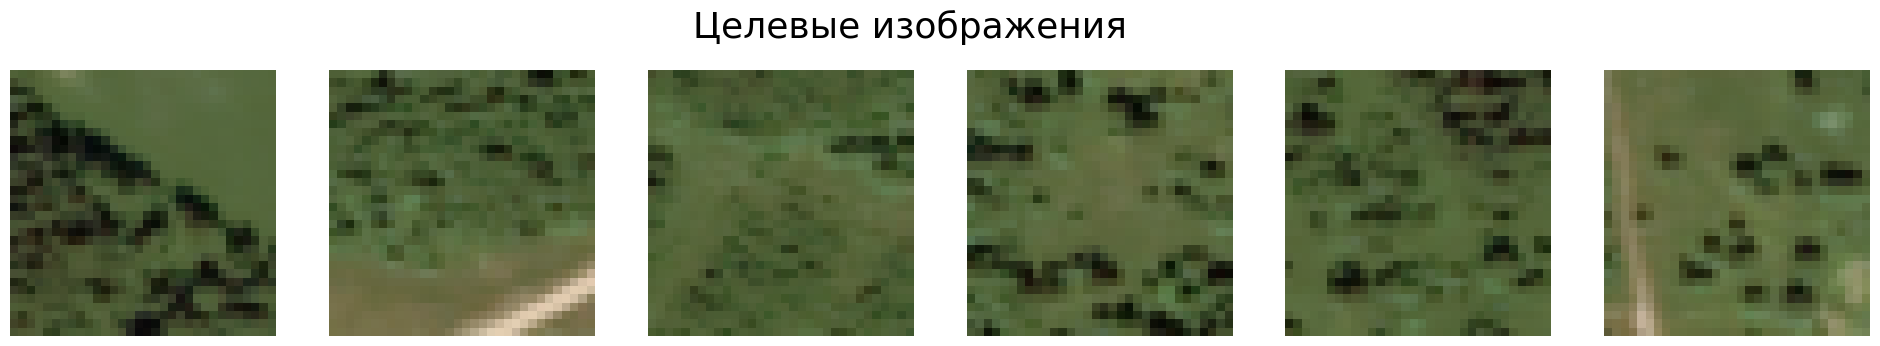

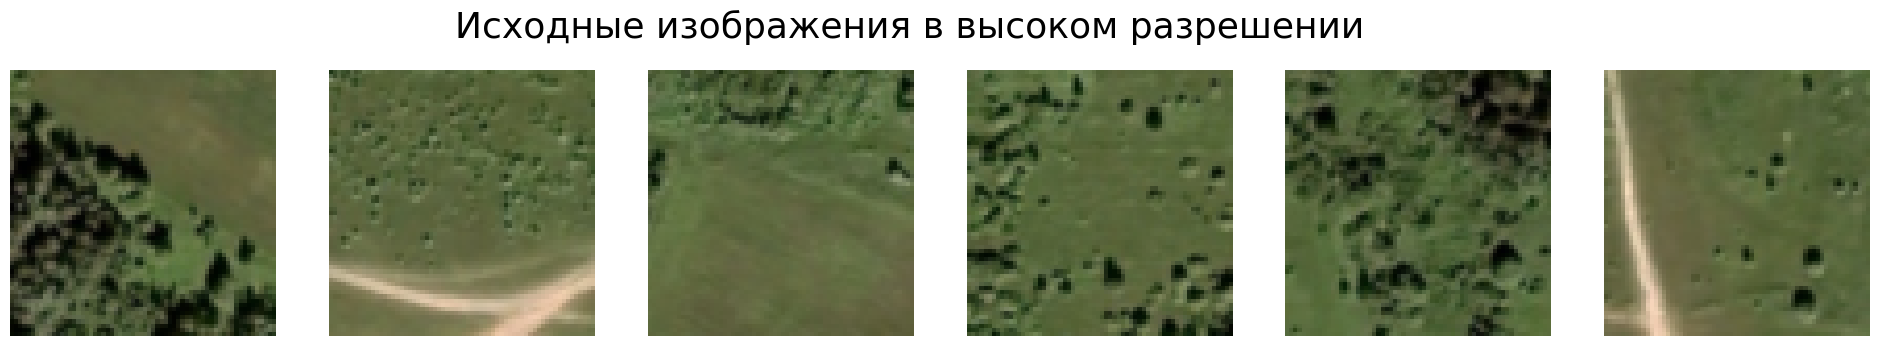

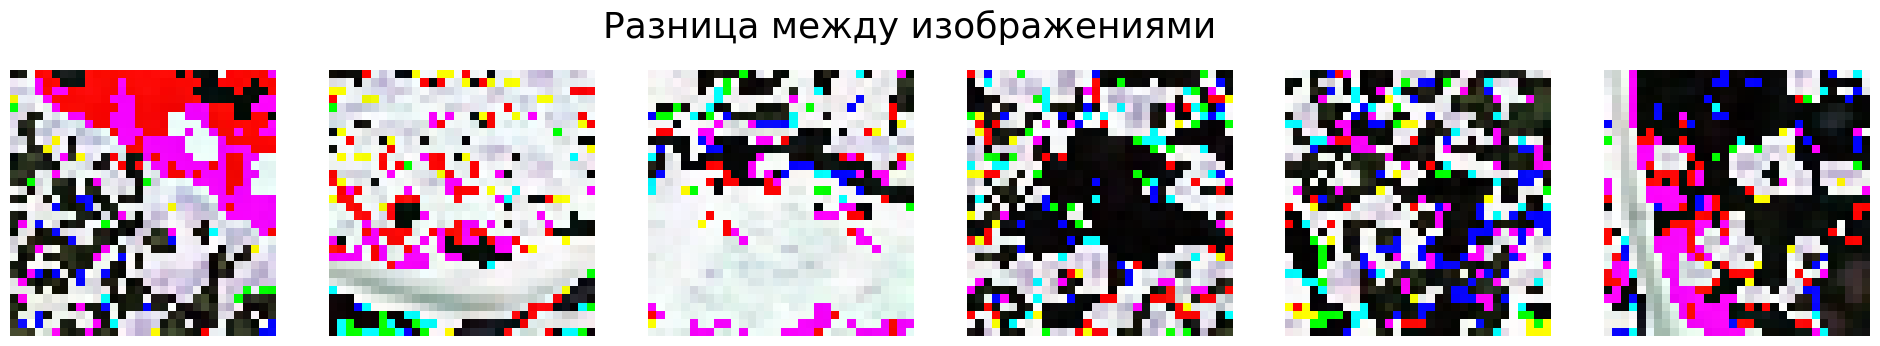

In [5]:
before, after, condition = next(iter(train_dataloader))
show_images(before.permute(0, 2, 3, 1).cpu(), title='Исходные изображения')
show_images(after.permute(0, 2, 3, 1).cpu(), title='Целевые изображения')
show_images(condition.permute(0, 2, 3, 1).cpu(), title='Исходные изображения в высоком разрешении')
show_images(torch.abs(after - before).permute(0, 2, 3, 1).int().cpu(), title='Разница между изображениями')

In [6]:
print(f'Размер датасета: {len(dataset)}')

Размер датасета: 857


Объявим класс модели и проведем обучение

In [7]:
class ClassConditionedUnet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = UNet2DModel(
            sample_size=32,
            in_channels=15, # 3 + 3 * 4
            out_channels=3,
            layers_per_block=2,
            block_out_channels=(224, 448, 672, 896),
            down_block_types=("AttnDownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D"),
            up_block_types=("AttnUpBlock2D", "AttnUpBlock2D", "AttnUpBlock2D", "AttnUpBlock2D"),
        )

    def forward(self, x, t, base):
        bs, ch, w, h = x.shape

        # Конкатенируем каналы шума с каналами исходного изображения
        net_input = torch.cat((x, base), 1) # (bs, 6, 32, 32)

        return self.model(net_input, t).sample # (bs, 3, 32, 32)

In [8]:
net = ClassConditionedUnet().to(device)

In [12]:
noise_scheduler = DDPMScheduler(num_train_timesteps=100, beta_schedule='squaredcos_cap_v2')
train_dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [ ]:
n_epochs = 5

net.train()

loss_fn = nn.MSELoss()

opt = torch.optim.Adam(net.parameters(), lr=0.0001)

losses = []

# The training loop
for epoch in range(n_epochs):
    for img_from, img_to, base in tqdm(train_dataloader):

        img_from = img_from.to(device) / 255
        img_to = img_to.to(device) / 255
        diff = img_to - img_from
        
        noise = torch.randn_like(diff)
        timesteps = torch.randint(0, 99, (diff.shape[0],)).long().to(device)
        noisy_diff = noise_scheduler.add_noise(diff, noise, timesteps)
        
        base = base.to(device) / 255
        base = unfold_batch_n_times(base, 1)

        pred = net(noisy_diff, timesteps, base)

        loss = loss_fn(pred, noise)

        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())

    avg_loss = sum(losses[-100:])/min(len(losses), 100)
    print(f'Finished epoch {epoch}. Average of the last 100 loss values: {avg_loss:05f}')

plt.plot(losses)

In [13]:
img_from, img_to, base = next(iter(train_dataloader))
x = torch.randn_like(img_from.float()).to(device)

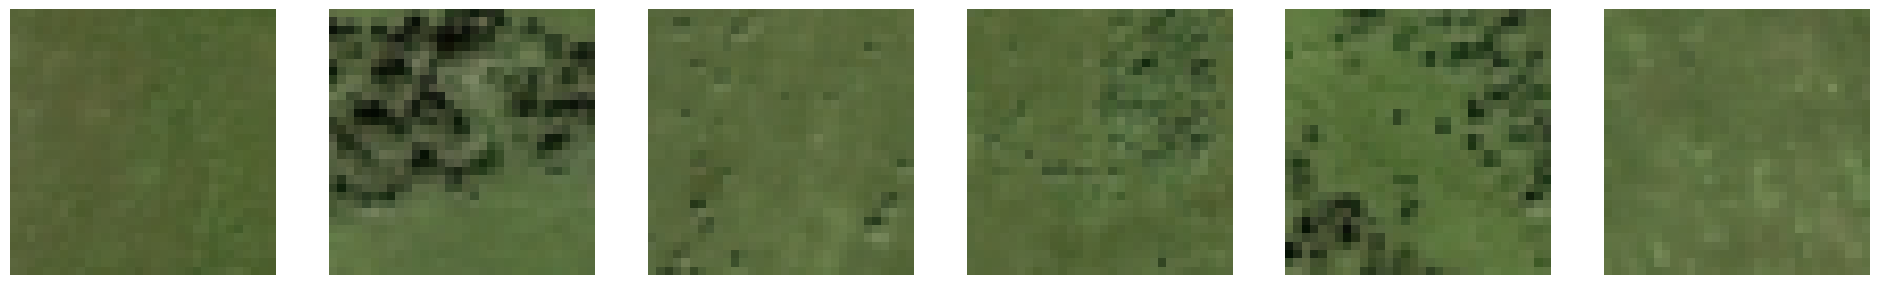

0it [00:00, ?it/s]

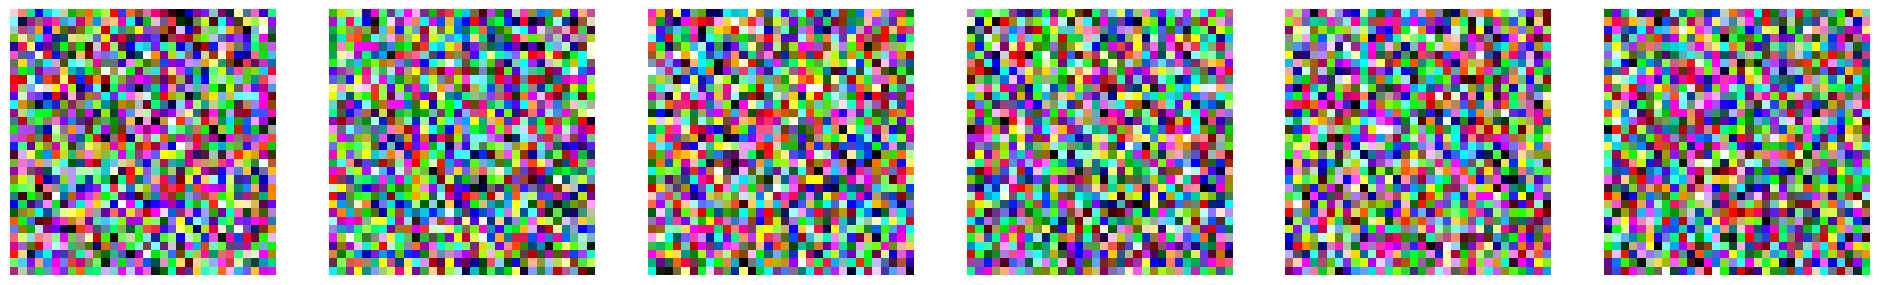

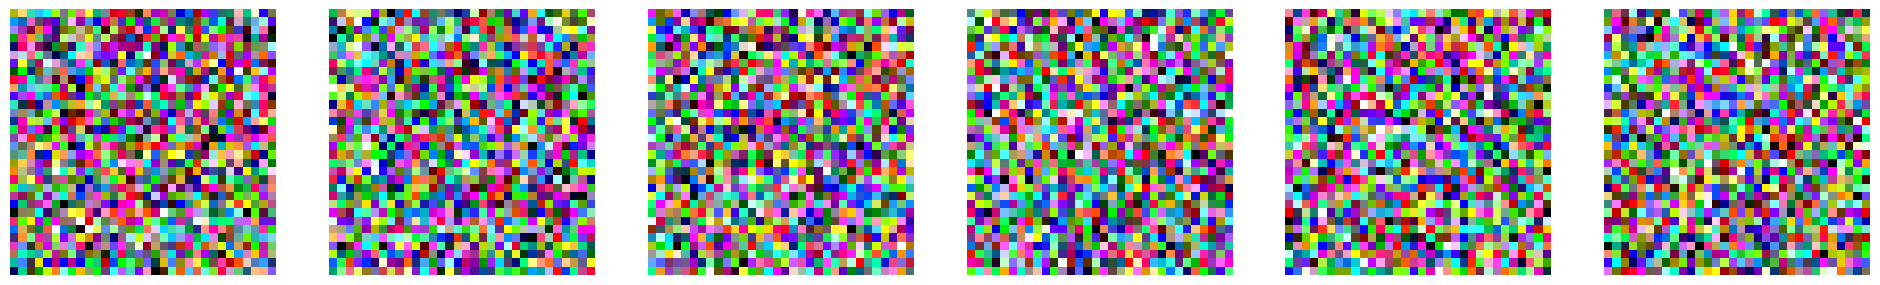

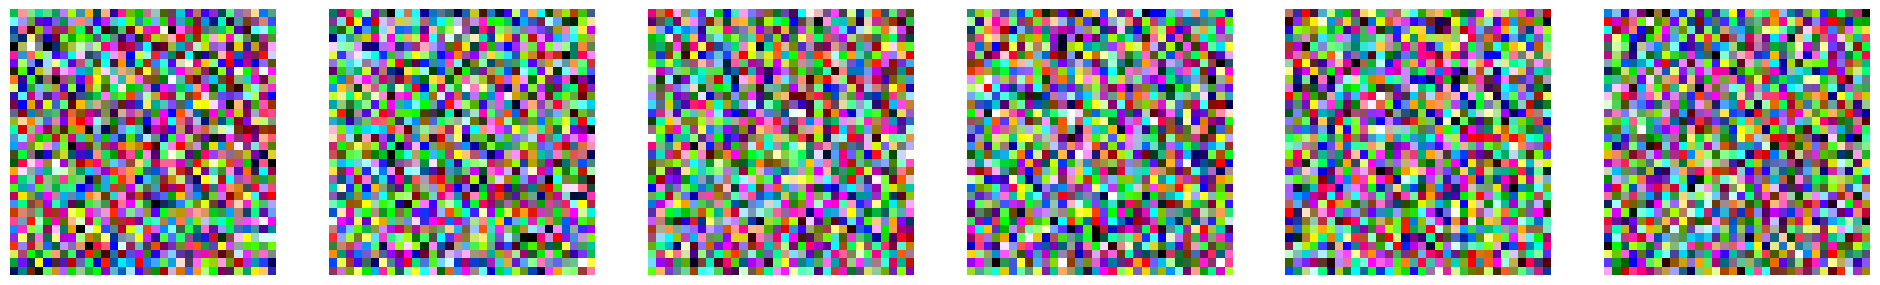

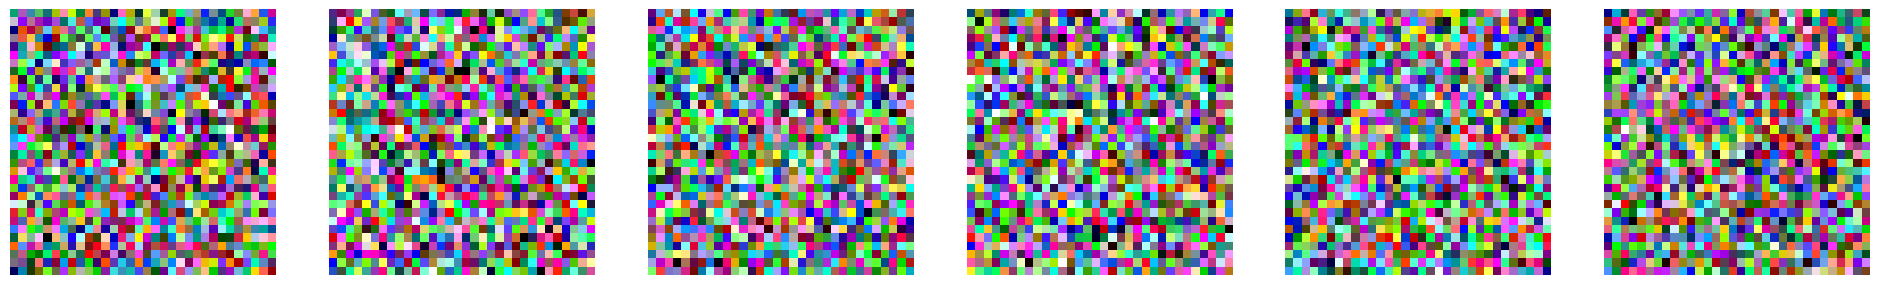

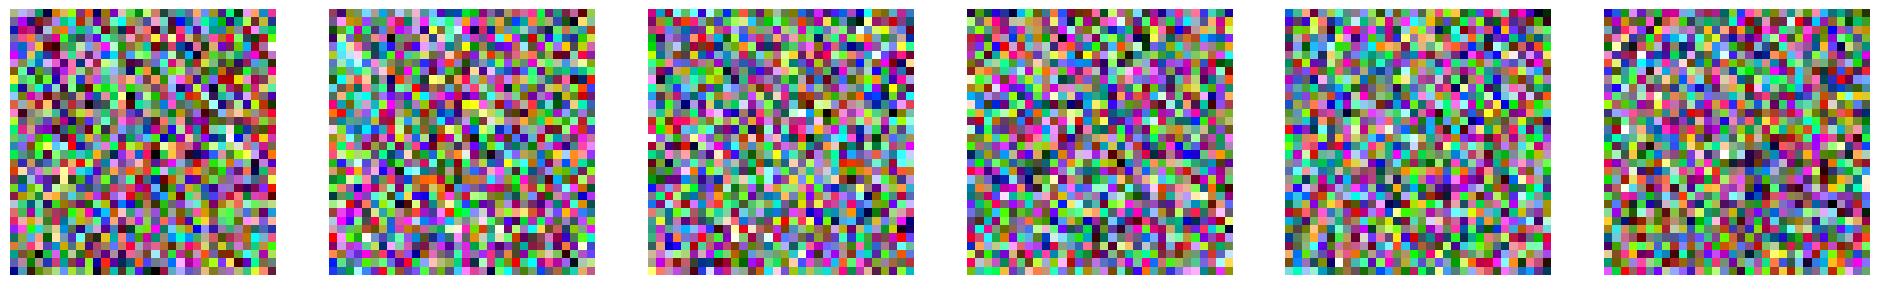

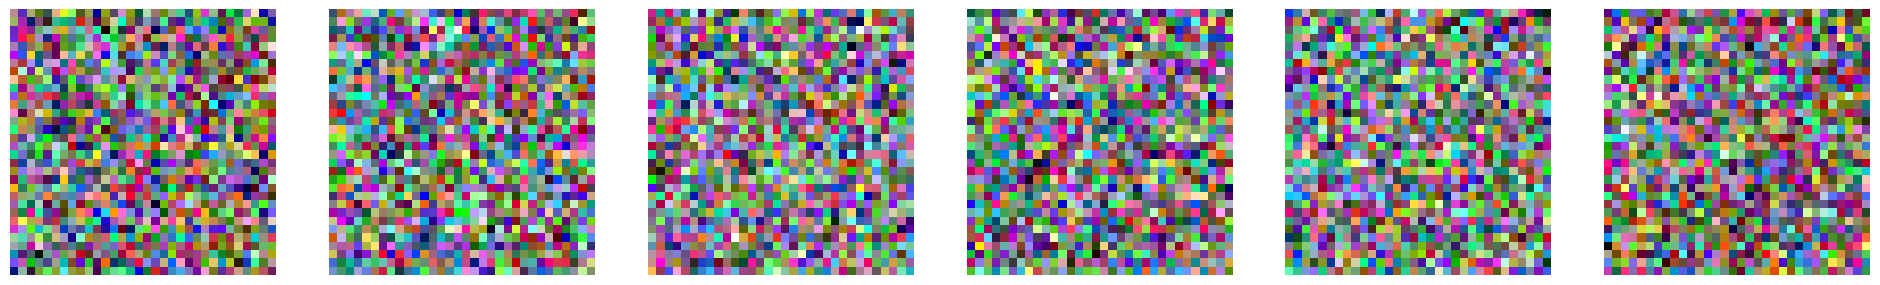

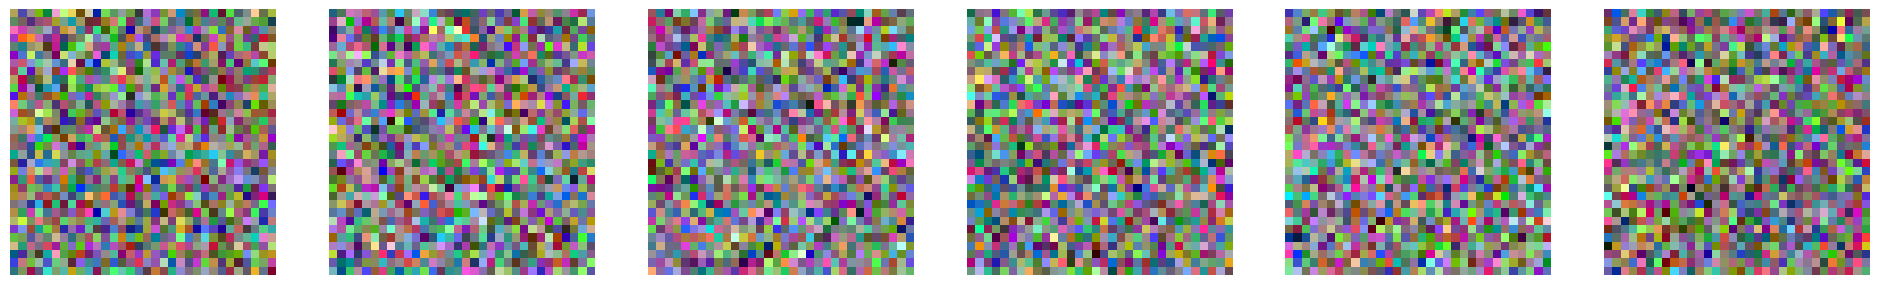

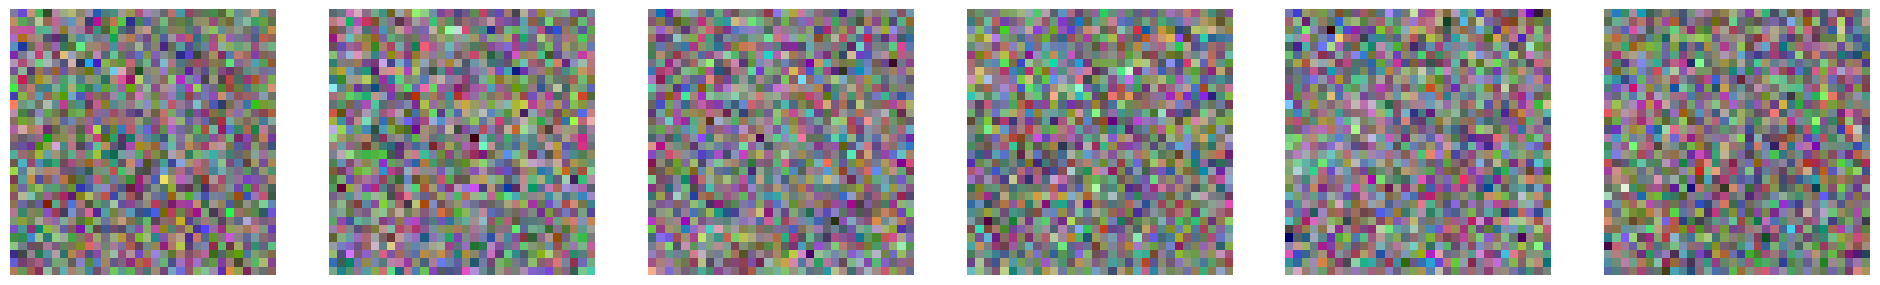

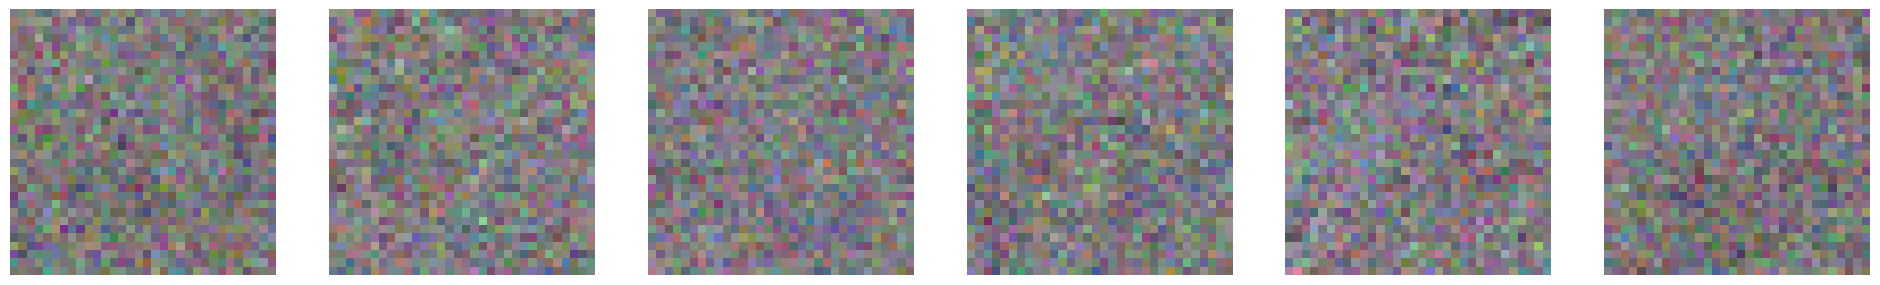

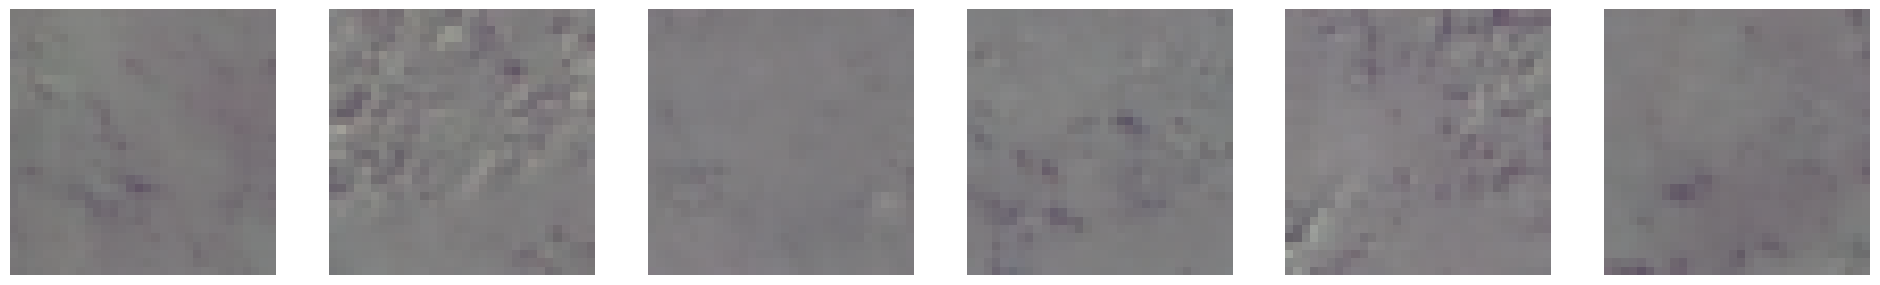

In [14]:
net.eval()

show_images(img_from.permute(0, 2, 3, 1)[:6].int().cpu())

for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
    with torch.no_grad():
        residual = net(x, t, unfold_batch_n_times(base.to(device), 1) / 255)
    x = noise_scheduler.step(residual, t, x).prev_sample
    if i % 10 == 9:
        show_images(((x + 1) / 2).permute(0, 2, 3, 1)[:6].cpu().clip(0, 1))

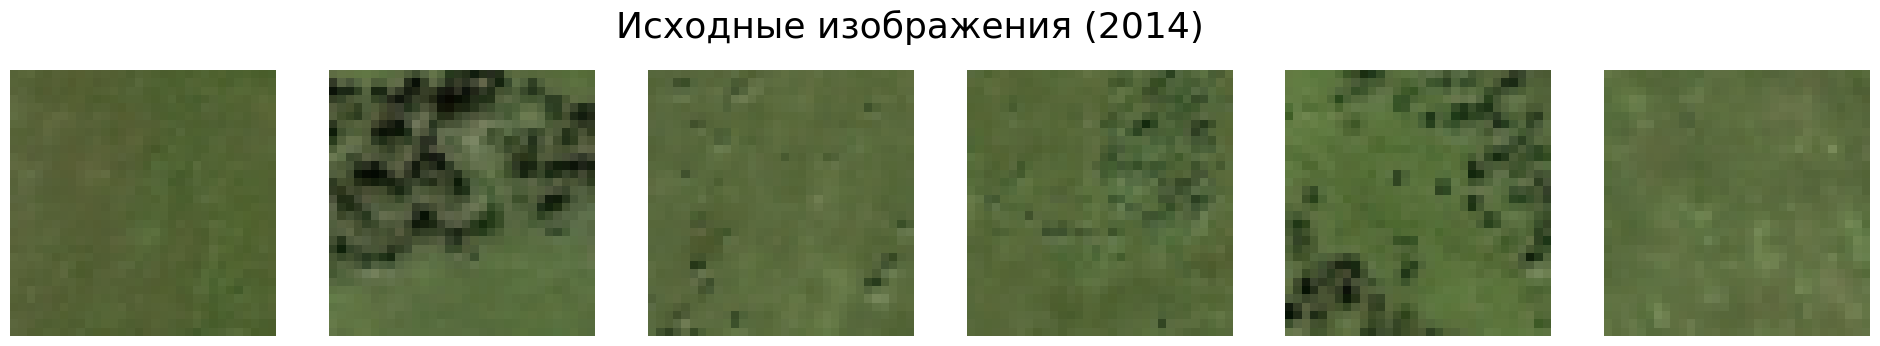

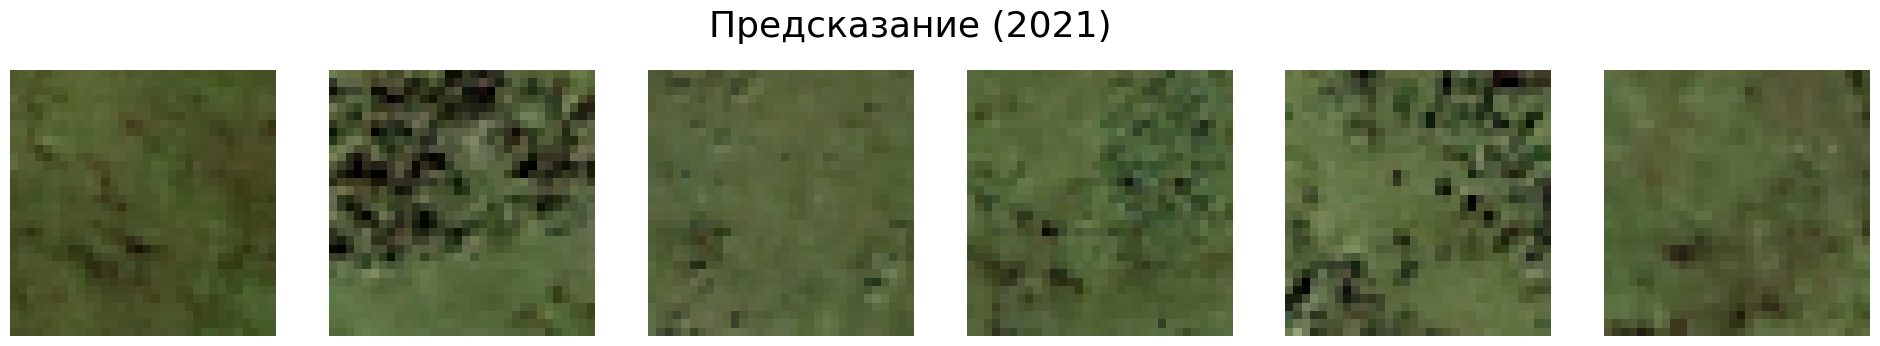

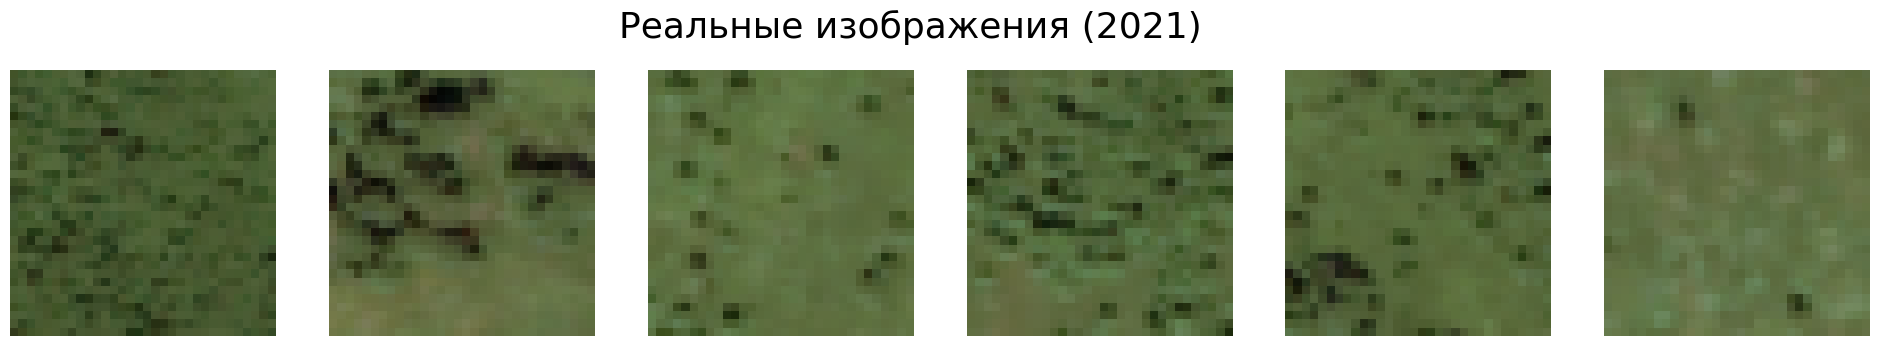

In [15]:
show_images(img_from.permute(0, 2, 3, 1)[:6].int().cpu(), title='Исходные изображения (2014)')
show_images((img_from / 255 + x.cpu()).clip(0, 1).permute(0, 2, 3, 1)[:6].float(), title='Предсказание (2021)')
show_images(img_to.permute(0, 2, 3, 1)[:6].int().cpu(), title='Реальные изображения (2021)')

In [27]:
torch.save(net.state_dict(), 'unet_weights')